In [ ]:
import pandas as pd
import json
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

# Authenticate.
from google.colab import auth
auth.authenticate_user()


Mounted at /content/drive


In [ ]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  11046      0 --:--:-- --:--:-- --:--:-- 11079
OK
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 n

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"
downsampled_path = f"{local_path}/raw-data/downsampled-data"


!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1721150763,"nanos":743071852},"severity":"INFO","message":"Start gcsfuse/2.3.1 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1721150763,"nanos":743550964},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [ ]:
!ls -lh {local_path}/raw-data/downsampled-data/N29_108EK113_07180705.JPG

-rw-r--r-- 1 root root 648K Jul 13 07:42 /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/downsampled-data/N29_108EK113_07180705.JPG


# Plot sample images

Text(0.5, 1.0, 'Sample image 2')

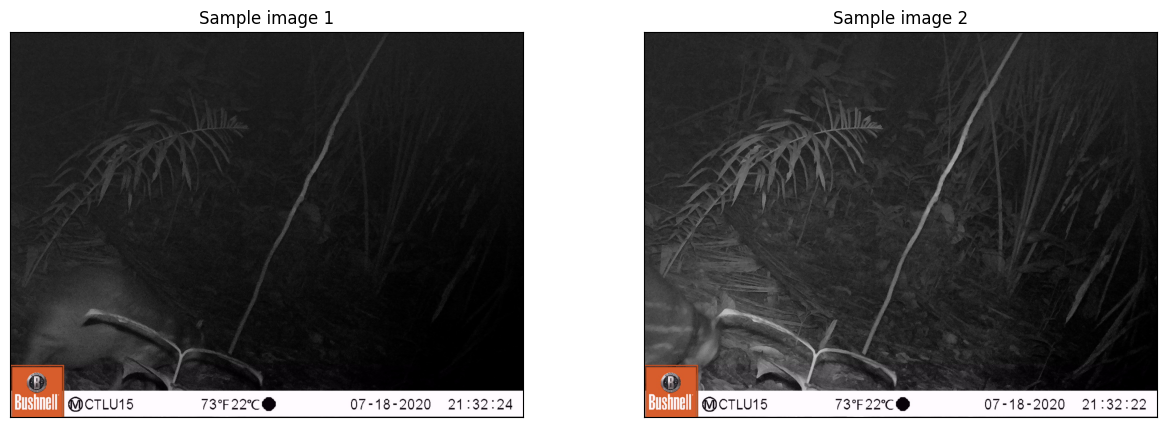

In [ ]:
# Test code with two images

img1 =  f"{local_path}/raw-data/downsampled-data/N29_108EK113_07180707.JPG"
img2 = f"{local_path}/raw-data/downsampled-data/N29_108EK113_07180705.JPG"

#read bos_species and spotted_paca images with imread
im1 = plt.imread(img1)
im2 = plt.imread(img2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.imshow(im1, cmap='gray',vmin=0, vmax=1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Sample image 1')


ax2.imshow(im2, cmap='gray',vmin=0, vmax=1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Sample image 2')

# Black out the logo and metadata at the bottom

## With sample images

Text(0.5, 1.0, 'Blacked out sample image 2')

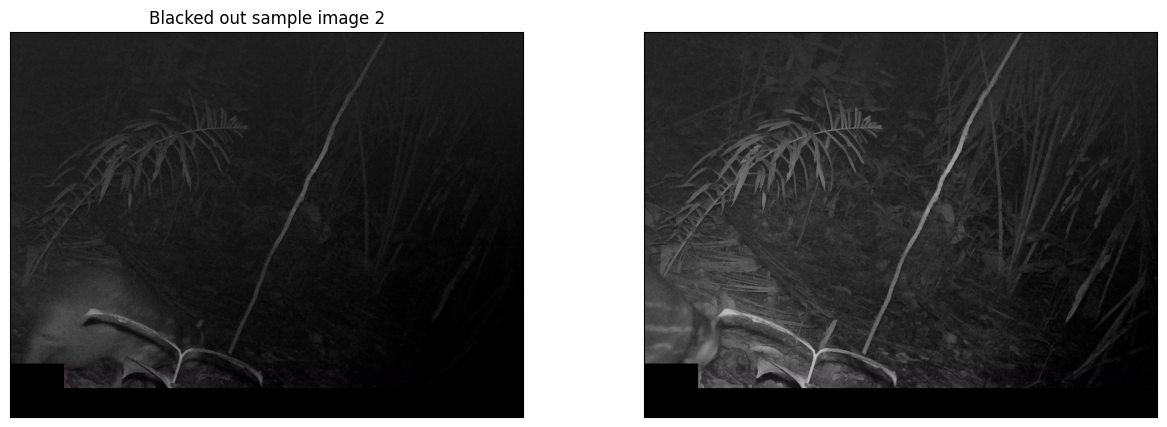

In [ ]:
im1_copy = im1.copy()
im2_copy = im2.copy()

#bottom row with metainfo
im1_copy[1332:,] = 0
im2_copy[1332:,] = 0

#logo
im1_copy[1240:1440,0:202] = 0
im2_copy[1240:1440,0:202] = 0

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.imshow(im1_copy, cmap='gray',vmin=0, vmax=1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Blacked out sample image 1')


ax2.imshow(im2_copy, cmap='gray',vmin=0, vmax=1)
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_title('Blacked out sample image 2')


## With all images in downsampled folder

In [ ]:
# Test with initial batch
num_images_to_process = 31860

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'raw-data', 'preprocessed_data')
os.makedirs(output_path, exist_ok=True)

# create df of unsaved images
df_not_saved = pd.Series([])

input_path = downsampled_path
image_counter = 0 #start counting batch

for file in tqdm(os.listdir(input_path)):
    if file.endswith(".JPG"):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file)

        if os.path.exists(output_file):
            print(f"Image {file} already exists in the output directory")
        else:
            try:
                # Read and process the image
                im = plt.imread(input_file)

                # Create a copy of the image data
                im_copy = im.copy()

                # Black out the logo and metadata at the bottom
                im_copy[1332:,] = 0
                im_copy[1240:1440,0:202] = 0

                # Save the processed image
                cv2.imwrite(output_file, im_copy)
                print(f"Image {file} processed and saved to {output_path}")

                # Update the DataFrame
                df_not_saved = pd.concat([df_not_saved, pd.Series(file)])


                # Increment the image counter
                image_counter += 1

                # Break the loop when batch size reached
                if image_counter >= num_images_to_process:
                    break
            except Exception as e:
                print(f"Error processing image {file}: {e}")

print(f"Number of images saved so far: {len(os.listdir(output_path))}")

Output hidden; open in https://colab.research.google.com to view.

# Visualize some of the preprocessed images to check process

In [ ]:
!ls -lh {local_path}/raw-data/preprocessed_data/

Streaming output truncated to the last 5000 lines.
-rw-r--r-- 1 root root  1.2M Jul 14 05:50 N29_101EK113_02140786.JPG
-rw-r--r-- 1 root root  1.2M Jul 14 05:50 N29_101EK113_02140787.JPG
-rw-r--r-- 1 root root  1.2M Jul 14 05:50 N29_101EK113_02140788.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140789.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140790.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140791.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140792.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140793.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140794.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140795.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140796.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140797.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140798.JPG
-rw-r--r-- 1 root root  1.3M Jul 14 05:50 N29_101EK113_02140799.J

Text(0.5, 1.0, 'Sample image 2')

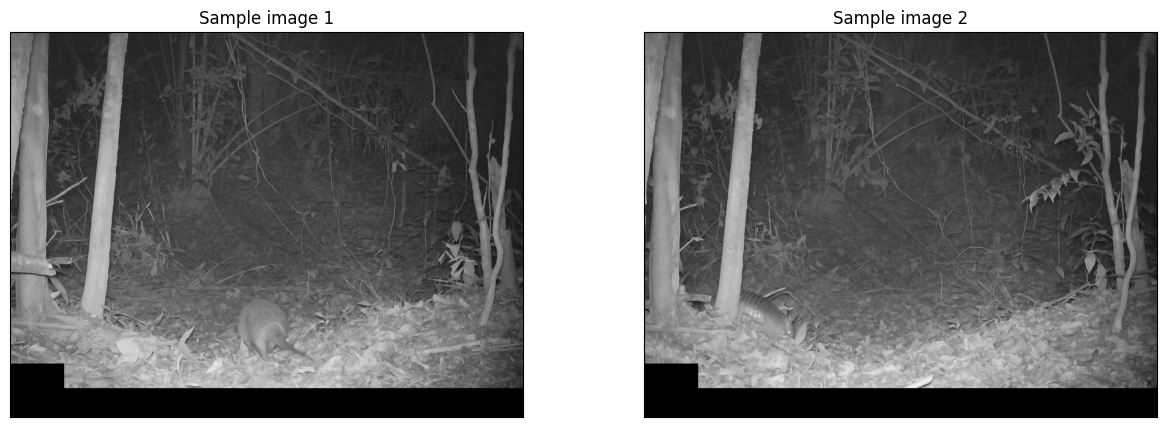

In [ ]:
# Test code with two images

img1 =  f"{local_path}/raw-data/preprocessed_data/A06_100EK113_01130051.JPG"
img2 = f"{local_path}/raw-data/preprocessed_data/A06_100EK113_02290316.JPG"

#read bos_species and spotted_paca images with imread
im1 = plt.imread(img1)
im2 = plt.imread(img2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.imshow(im1, cmap='gray',vmin=0, vmax=1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Sample image 1')


ax2.imshow(im2, cmap='gray',vmin=0, vmax=1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Sample image 2')